# Проект. Проверка гипотез для увеличения выручки интернет-магазина и анализ A/B тестирования

# Описание проекта

У нас в распоряжении есть данные о гипотезах для увеличения выручки интернет магазина, а также данные о заказах и количестве пользователей для двух групп A/B теста. Необходимо приоретизировать гипотезы и проанализировать результаты A/B теста.  

# Описание данных

Файл `hypothesis.csv` содержит данные о гипотезах.

Структура данных в файле:
* Hypothesis — краткое описание гипотезы;
* Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл `orders.csv` содержит данные о заказах.

Стуктура данных в файле:
* transactionId — идентификатор заказа;
* visitorId — идентификатор пользователя, совершившего заказ;
* date — дата, когда был совершён заказ;
* revenue — выручка заказа;
* group — группа A/B-теста, в которую попал заказ.

Файл `hypothesis.csv` содержит данные о количестве пользователей.

Стуктура данных в файле:
* date — дата;
* group — группа A/B-теста;
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

# Этапы проекта 

 1. Обзор данных
 2. Подготовка данных к анализу
 3. Исследовательский анализ
* 3.1 Приоритизация гипотез
* 3.2 Анализ A/B-теста
 4. Выводы и рекомендации

## Обзор данных

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
from scipy import stats as st
import numpy as np

Сделаем количество отображаемых столбцов таблиц неограниченным.

In [2]:
pd.set_option('display.max_columns', None)

Сделаем длину отображаемых ячеек в таблицах неограниченной.

In [3]:
pd.set_option('display.max_colwidth', None)

Откроем и сохраним в переменные данные из файлов.

In [4]:
hypothesis, orders, visitors = (
                            pd.read_csv('hypothesis.csv'),
                            pd.read_csv('orders.csv'),
                            pd.read_csv('visitors.csv')
                            )

Определим функции для обзора информации, содержащейся в таблицах.

Зададим функцию для определения количества пропусков и их доли.

In [5]:
def nan_values(table):
    nan_count = table.isna().sum()
    nan_percent = round(100 * nan_count / len(table), 2) 
    duplicates_count = table.duplicated().sum()
    
    
    nan_values_table = pd.DataFrame({'Столбец': table.columns, 
                                     'Количество пропусков': nan_count,
                                     'Доля пропусков, %': nan_percent}).reset_index(drop=True)
    return nan_values_table                                            

Зададим функцию для обзора информации, содержащейся в таблице.

In [6]:
def get_table_info(table):
    print('Общая информация о таблице:')
    print()
    display(table.info())
    print()
    print('Первые пять строк таблицы:')
    display(table.head())
    print()
    print('Информация о пропусках и дубликатах:')
    display(nan_values(table))
    print()
    print('Количество строк-дубликатов:', table.duplicated().sum())

Получим информацию о данных из таблицы `hypothesis`.

In [7]:
get_table_info(hypothesis)

Общая информация о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None


Первые пять строк таблицы:


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1



Информация о пропусках и дубликатах:


,Столбец,Количество пропусков,"Доля пропусков, %"
0,Hypothesis,0,0.0
1,Reach,0,0.0
2,Impact,0,0.0
3,Confidence,0,0.0
4,Efforts,0,0.0



Количество строк-дубликатов: 0


**Таблица `hypothesis` содержит 9 различных гипотез для увеличения выручки интернет магазина. Для каждой из них есть оценки RICE.**

**Пропусков и строк-дубликатов в этой таблице нет. В дальнейшем стоит привести названия столбцов к нижнему регистру.**

Получим информацию о данных из таблицы `orders`.

In [8]:
get_table_info(orders)

Общая информация о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None


Первые пять строк таблицы:


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B



Информация о пропусках и дубликатах:


,Столбец,Количество пропусков,"Доля пропусков, %"
0,transactionId,0,0.0
1,visitorId,0,0.0
2,date,0,0.0
3,revenue,0,0.0
4,group,0,0.0



Количество строк-дубликатов: 0


Определим также когда проводилось A/B тестирование.

In [9]:
print('Минимальная дата проведения тестирования:', orders['date'].min())
print('Максимальная дата проведения тестирования:',orders['date'].max())

Минимальная дата проведения тестирования: 2019-08-01
Максимальная дата проведения тестирования: 2019-08-31


Проверим как разбиты транзакции по группам.

In [10]:
orders['group'].value_counts().reset_index().rename(columns={'group':'Количество транзакций','index':'Группа'})

,Группа,Количество транзакций
0,B,640
1,A,557


**Итак, таблица `orders` содержит данные о 1197 транзакциях двух приблизительно одинаковых по их количеству групп за август 2019 года.**

**Пропусков и строк-дубликатов в этой таблице нет. В дальнейшем стоит привести названия столбцов к нижнему регистру, а затем привести некоторые из них к змеиному регистру, а также привести тип данных в столбце `date` к `datetime`.**

Получим информацию о данных из таблицы `visitors`.

In [11]:
get_table_info(visitors)

Общая информация о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None


Первые пять строк таблицы:


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756



Информация о пропусках и дубликатах:


,Столбец,Количество пропусков,"Доля пропусков, %"
0,date,0,0.0
1,group,0,0.0
2,visitors,0,0.0



Количество строк-дубликатов: 0


Проверим, за какой период представлены данные в таблице `visitors`.

In [12]:
print('Минимальная дата проведения тестирования:', visitors['date'].min())
print('Максимальная дата проведения тестирования:',visitors['date'].max())

Минимальная дата проведения тестирования: 2019-08-01
Максимальная дата проведения тестирования: 2019-08-31


Этот период соответствует периоду в таблице `orders`.

Проверим как разбиты данные о количестве пользователей по группам.

In [13]:
visitors['group'].value_counts().reset_index().rename(columns={'group':'Количество записей','index':'Группа'})

,Группа,Количество записей
0,B,31
1,A,31


**Таблица `visitors` содержит данные о количестве пользователей за каждый день августа 2019 года для двух групп тестирования.**

**Пропусков и строк-дубликатов в этой таблице нет. В дальнейшем стоит привести тип данных в столбце `date` к типу `datetime`.**

## Подготовка данных к анализу

Приведем названия столбцов в таблицах `hypothesis` и `orders` к нижнему регистру.

In [14]:
hypothesis.columns = hypothesis.columns.str.lower()
orders.columns = orders.columns.str.lower()

Приведем к змеиному регистру столбцы `transactionid` и `visitorid` таблицы `orders`.

In [15]:
orders = orders.rename(columns={'transactionid':'transaction_id', 'visitorid':'visitor_id'})

Заменим тип данных в столбцах `date` таблиц `orders` и `visitors` на `datetime` для корректной дальнейшей работы с датой из них.

In [16]:
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

Проверим изменения.

In [17]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Названия столбцов приведены к нижнему регистру.

In [18]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


Названия столбцов приведены к нижнему и змеиному регистру. Тип данных в столбце `date` изменён на `datetime`.

In [19]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Тип данных в столбце `date` изменён на `datetime`.

**При подготовке данных к анализу было исправлено нарушение стиля в названии столбцов таблиц и были изменены типы данных в столбцах, в которых была указана дата.**

**Данные готовы для исследовательского анализа.**

## Исследовательский анализ

### Приоритизация гипотез

Применим фреймворк `ICE` для приоритизации гипотез.

Рассчитаем для каждой из гипотез показатель `ICE`.

In [20]:
hypothesis['ice'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

Отстортируем гипотезы по убыванию значения показателя `ICE`.

In [21]:
ice_table = (hypothesis[['hypothesis','ice']]
 .sort_values(by = 'ice', ascending=False)
 .rename(columns={'hypothesis':'Гипотеза','ice':'ICE'})
)
ice_table['ICE'] = round(ice_table['ICE'], 2)
ice_table

,Гипотеза,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


**Гипотеза` `"Запустить акцию, дающую скидку на товар в день рождения"` `имеет наибольший показатель `ICE`.**

Применим фреймворк `RICE` для приоритизации гипотез.

Рассчитаем для каждой из гипотез показатель `RICE`

In [22]:
hypothesis['rice'] = hypothesis['ice'] * hypothesis['reach']

Отстортируем гипотезы по убыванию значения показателя `RICE`.

In [23]:
(hypothesis[['hypothesis','rice']]
 .sort_values(by = 'rice', ascending=False)
 .rename(columns={'hypothesis':'Гипотеза','rice':'RICE'})
)

,Гипотеза,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


**Гипотеза` `"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок	"` ` оказалась наиболее приоритетной по показателю `RICE`.**

**Приоритизация при применении фреймворка `RICE` изменилась, ввиду того, что стал учитываться показатель `reach`, отражающий оценку количества пользователей, которых затронет изменение. Так, например, гипотеза ` `"Запустить акцию, дающую скидку на товар в день рождения"` ` из-за низкого значения оценки `reach = 1` оказалась менее приоритетной по показателю `RICE`.**

**В качестве наиболее приоритетной возьмем гипотезу `-`"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок", выбранную с применением фреймворка RICE.**

### Анализ A/B-теста

Проведём анализ полученных данных A/B-тестирования.

Рассчитаем кумулятивные метрики в разрезе групп тестирования: суммарное число заказов, суммарную выручку, количество пользователей до выбранной даты включительно.

In [24]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']


visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']


ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

Проверим, не попадают ли какие-либо пользователи в обе группы тестирования.

Создадим таблицу с идентификаторами пользователей, попавших сразу в обе группы тестирования.

In [25]:
two_group_users = orders.groupby('visitor_id').agg({'group':'nunique'}).rename(columns={'group':'groups_count'})
two_group_users = two_group_users.query('groups_count > 1')

In [26]:
two_group_users.head()

,groups_count
visitor_id,
8300375,2
199603092,2
232979603,2
237748145,2
276558944,2


Посчитаем количество таких пользователей.

In [27]:
print('Количество пользователей, попавших сразу в две группы тестирования:', len(two_group_users))

Количество пользователей, попавших сразу в две группы тестирования: 58


Определим количество пользователей в обеих группах и общее количество пользователей с учетом того, что некоторые из них попадают в обе группы сразу.

In [28]:
print('Общее количество пользователей -', orders['visitor_id'].nunique())
print('Количество пользователей в группе А -', orders.query('group == "A"')['visitor_id'].nunique())
print('Количество пользователей в группе В -', orders.query('group == "B"')['visitor_id'].nunique())

Общее количество пользователей - 1031
Количество пользователей в группе А - 503
Количество пользователей в группе В - 586


Доля пользователей, попавших в обе группы, для каждой из групп приблизительно равна одной десятой. Участие этих пользователей сразу в обеих группах может исказить результаты. Но известны только идентификаторы пользователей, совершивших хотя бы один платеж, а идентификаторы не совершивших платёж - неизвестны, поэтому удаление таких пользователей может также исказить результаты в сторону "неплатящих" пользователей. Лучше оставить таких пользователей в анализируемых данных.

Выведем первые 5 строк таблицы, содержащей данные о кумулятивных метриках двух групп.

In [29]:
data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Описание данных в таблице `data`:
* ordersPerDateA — количество заказов в выбранную дату в группе A;
* revenuePerDateA — суммарная выручка в выбранную дату в группе A;
* ordersPerDateB — количество заказов в выбранную дату в группе B;
* revenuePerDateB — суммарная выручка в выбранную дату в группе B;
* ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;
* revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A;
* ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;
* revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;
* visitorsPerDateA — количество пользователей в выбранную дату в группе A;
* visitorsPerDateB — количество пользователей в выбранную дату в группе B;
* visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;
* visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B.

Построим график кумулятивной выручки по группам.

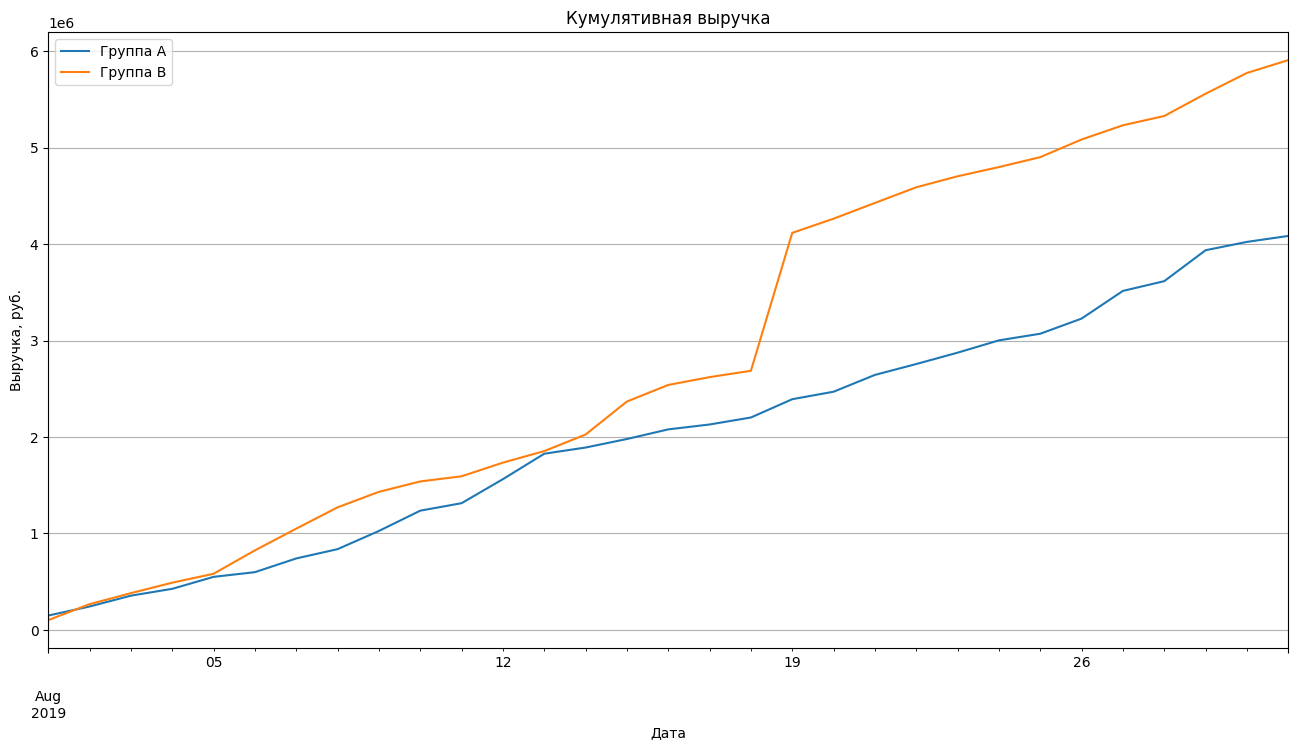

In [30]:
(data[['date','revenueCummulativeA', 'revenueCummulativeB']]
 .rename(columns={'revenueCummulativeA':'Группа A', 'revenueCummulativeB':'Группа B'})
 .plot(x = 'date', grid=True, title = "Кумулятивная выручка", figsize=(16,8))
 .set(xlabel = 'Дата', ylabel = 'Выручка, руб.')
);

**Кумулятивная выручка группы B после 2 августа стабильно выше кумулятивной выручки группы А. На конец августа этот показатель для группы B оказался в полтора раза выше. Заметен также резкий скачок кумулятивной выручки в группе B с 18 на 19 августа, который связан, скорее всего, с крупным/крупными заказами в этот день.**

Построим график кумулятивного среднего чека по группам.

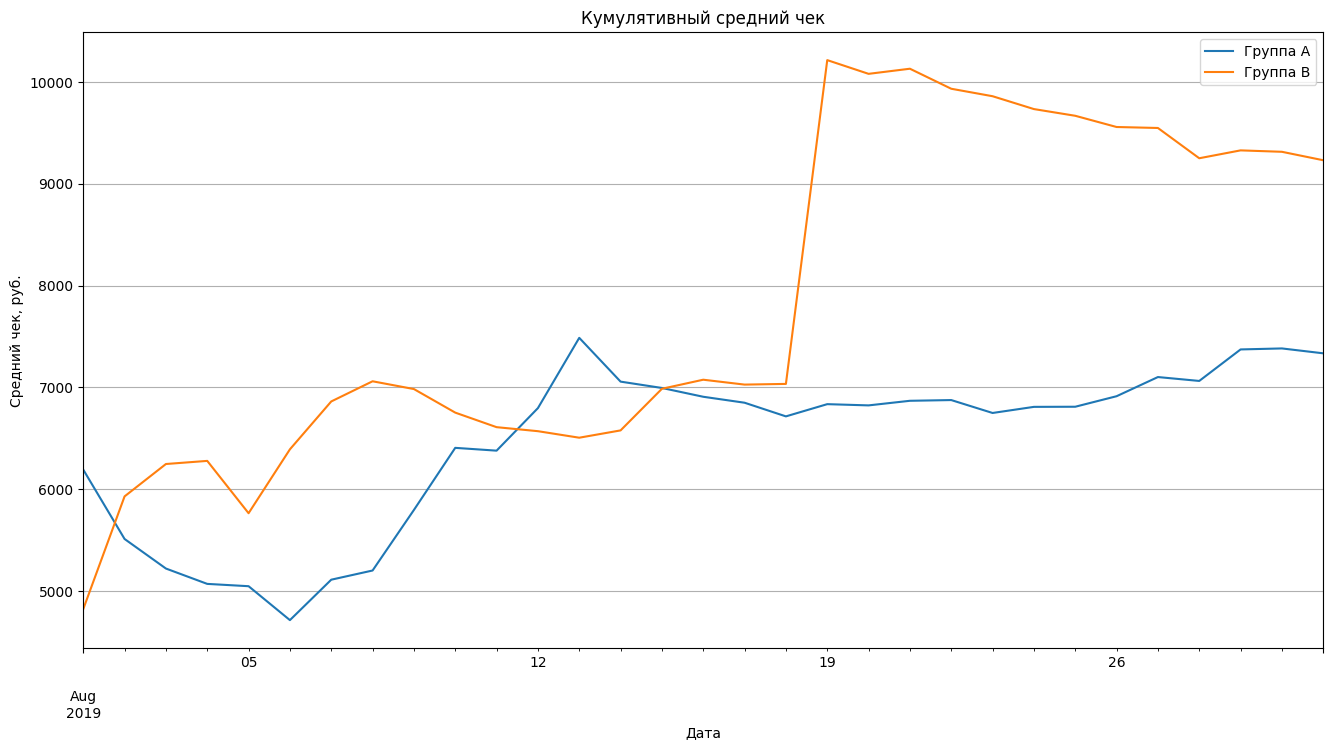

In [31]:
data['cumulative_average_check_A'] = data['revenueCummulativeA'] / data['ordersCummulativeA']
data['cumulative_average_check_B'] = data['revenueCummulativeB'] / data['ordersCummulativeB']

(data[['date','cumulative_average_check_A', 'cumulative_average_check_B']]
 .rename(columns={'cumulative_average_check_A':'Группа A', 'cumulative_average_check_B':'Группа B'})
 .plot(x = 'date', grid=True, title = "Кумулятивный средний чек", figsize=(16,8))
 .set(xlabel = 'Дата', ylabel = 'Средний чек, руб.')
);

**Кумулятивный средний чек группы В в период с 11 по 15 августа падает ниже уровня группы А, но затем резко растет, что еще раз подтверждает, что в группе В в период 18-19 августа была крупная покупка, которая увеличила размер кумулятивного среднего чека.**

Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

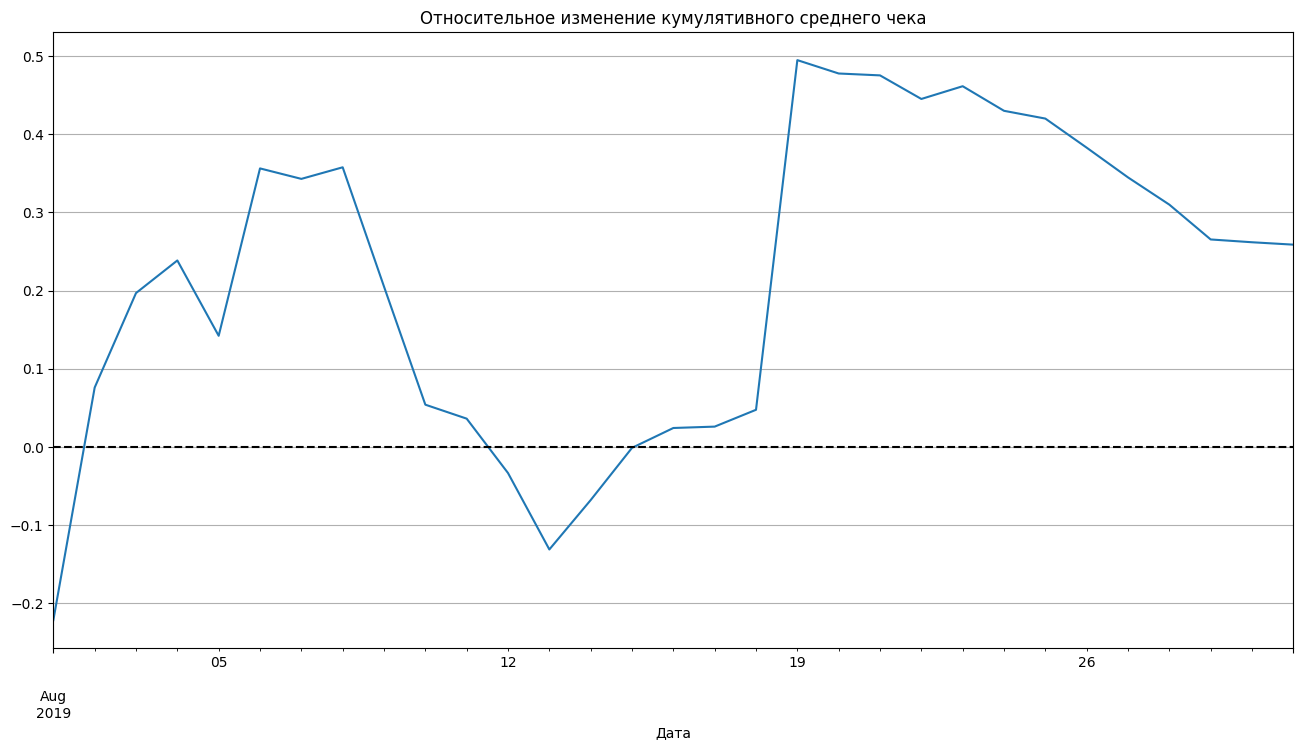

In [32]:
data['rel_cumulative_average_check'] = (data['cumulative_average_check_B'] / data['cumulative_average_check_A']) - 1

(data[['date','rel_cumulative_average_check']]
 .plot(x = 'date',grid=True, title = "Относительное изменение кумулятивного среднего чека",legend=False,figsize=(16,8))
 .set(xlabel = 'Дата')
);
plt.axhline(y=0, color='black', linestyle='--');

**Относительная разница кумулятивных средних чеков колеблется: наблюдается её относительный рост примерно до 8 августа, затем спад до 13 августа включительно, снова подъем до 19 августа, и вновь уменьшение, но не ниже нулевого уровня.**

Построим график кумулятивного среднего количества заказов на посетителя по группам.

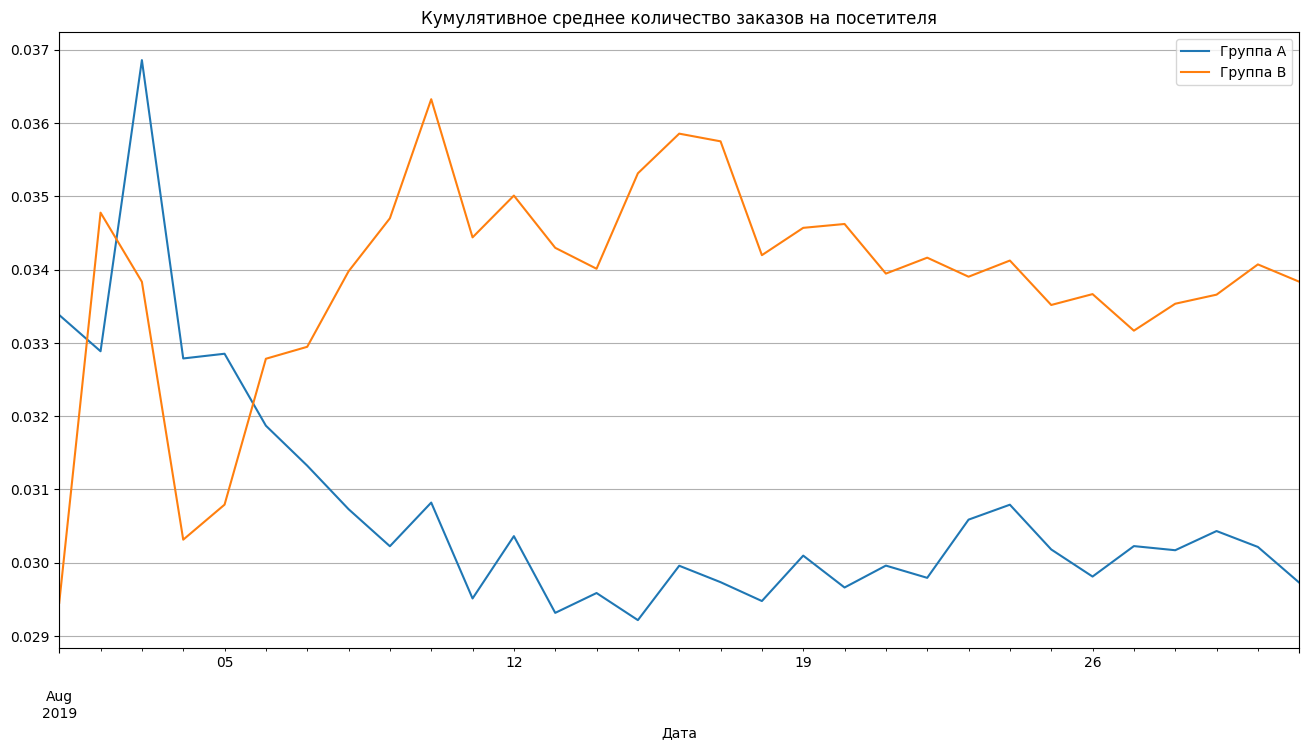

In [33]:
data['cumulative_conversionA'] = data['ordersCummulativeA'] / data['visitorsCummulativeA']
data['cumulative_conversionB'] = data['ordersCummulativeB'] / data['visitorsCummulativeB']

(data[['date','cumulative_conversionA', 'cumulative_conversionB']]
 .rename(columns={'cumulative_conversionA':'Группа A', 'cumulative_conversionB':'Группа B'})
 .plot(x = 'date', grid=True, title = "Кумулятивное среднее количество заказов на посетителя", figsize=(16,8))
 .set(xlabel = 'Дата')
);

**Начиная с 6 августа кумулятивное среднее количество заказов на посетителя в группе B оказывается больше.**

Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

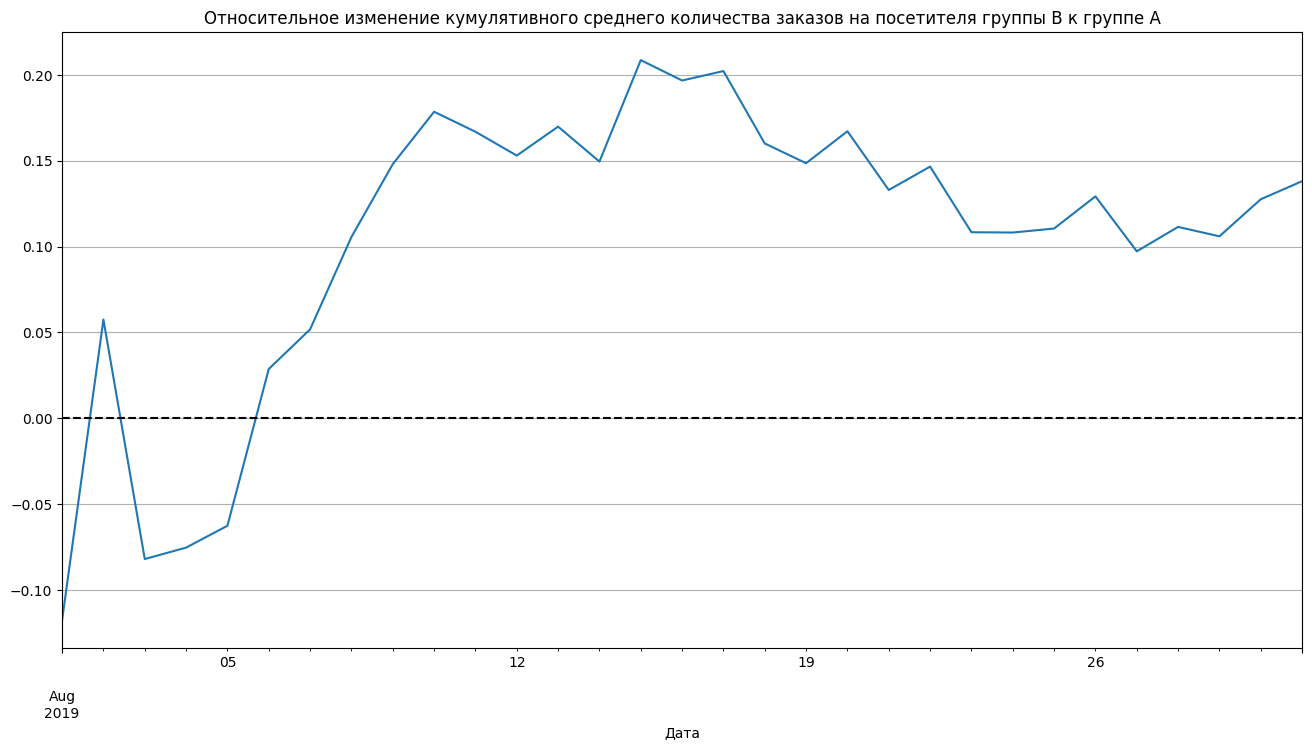

In [34]:
data['rel_cumulative_conversion'] = (data['cumulative_conversionB'] / data['cumulative_conversionA']) - 1

(data[['date','rel_cumulative_conversion']] 
 .plot(x = 'date', grid=True, 
       title = "Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A",
       figsize=(16,8), legend=False)
 .set(xlabel = 'Дата')
);
plt.axhline(y=0, color='black', linestyle='--');

**Данный график в дополнение к предыдущему показывает, что у кумулятивного среднего количества заказов на посетителя группы B по отношению к этому показателю группы А есть тенденция к уменьшению.**  

Построим точечный график количества заказов по пользователям.

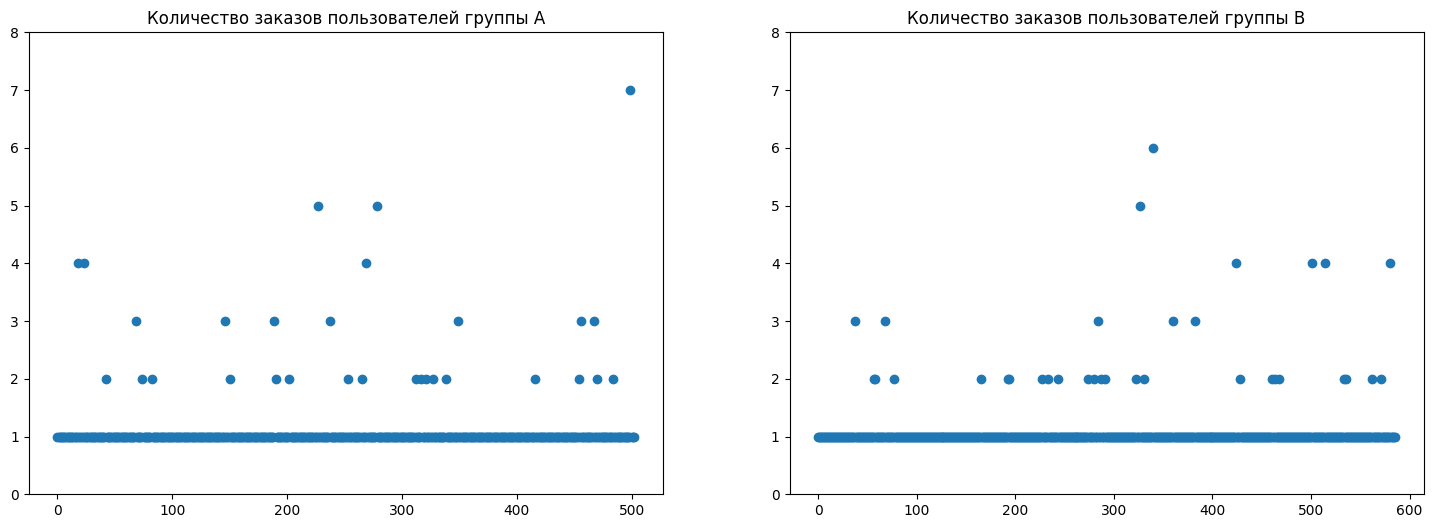

In [35]:
ordersByUsersA = orders.query('group == "A"').groupby('visitor_id',as_index=False)['transaction_id'].count()
ordersByUsersA.columns = ['visitor_id', 'order_count']

ordersByUsersB = orders.query('group == "B"').groupby('visitor_id',as_index=False)['transaction_id'].count()
ordersByUsersB.columns = ['visitor_id', 'order_count']

plt.figure(figsize=(18,6))

plt.subplot(1, 2, 1)
x_values = pd.Series(range(0,len(ordersByUsersA)))
plt.scatter(x_values, ordersByUsersA['order_count']) 
plt.title("Количество заказов пользователей группы А")
plt.ylim(0,8)

plt.subplot(1, 2, 2)
x_values = pd.Series(range(0,len(ordersByUsersB)))
plt.scatter(x_values, ordersByUsersB['order_count'] ) 
plt.title("Количество заказов пользователей группы В")
plt.ylim(0,8)

plt.show()

**Заметно, что в обеих группах подавляющее большинство пользователей сделали по одному заказу, некоторые - по два, и очень редко большее число раз.**

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя.

In [36]:
print(np.percentile(ordersByUsersA['order_count'], [95, 99]))

[2.   3.98]


В группе А не более 5% клиентов, которые оформили более 2 заказов, и не более 1% оформивших более 4 заказов.

In [37]:
print(np.percentile(ordersByUsersB['order_count'], [95, 99])) 

[2.   3.15]


В группе B не более 5% клиентов, которые оформили более 2 заказов, и не более 1% оформивших более 3 заказов.

**95-й и 99-й перцентили количества заказов на одного пользователя соответственно:**
* **для группы А: 2 и 3.98 заказа на пользователя;**
* **для группы В: 2 и 3.15 заказа на пользователя.**

**Примем за аномальных пользователей в обеих группах тех, кто совершил от 3 заказов и более. Так мы уберём пользователей с наибольшим числом заказов.**

Построим точечный график стоимостей заказов.

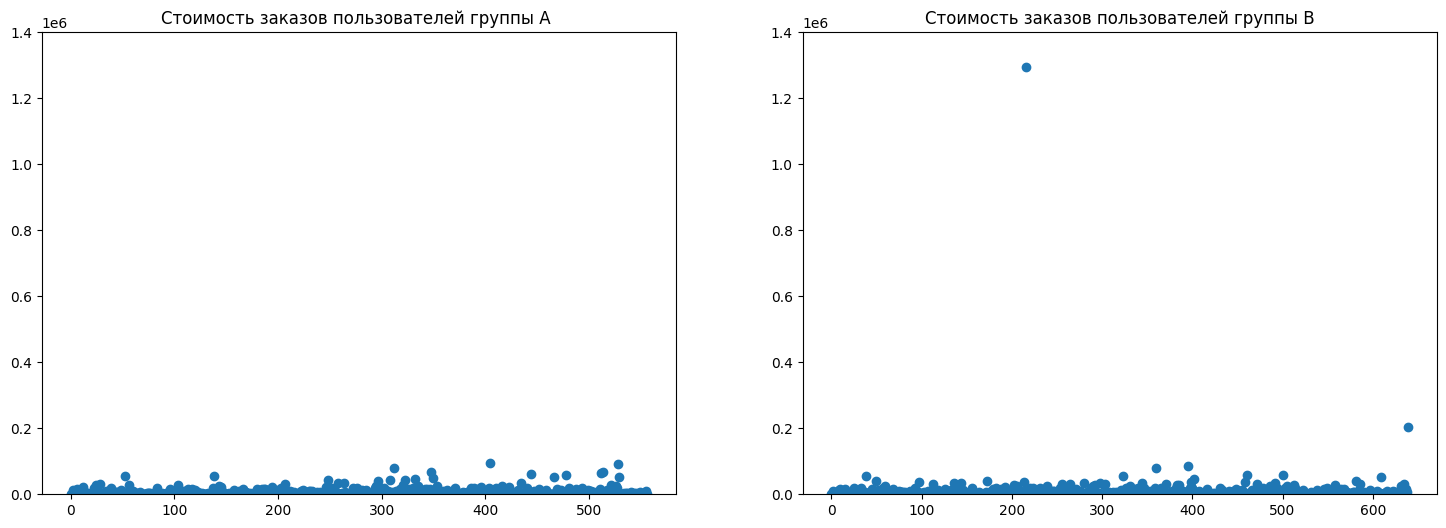

In [38]:
revenue_per_ordersA = orders.query('group == "A"')['revenue']
revenue_per_ordersB = orders.query('group == "B"')['revenue']

plt.figure(figsize=(18,6))

plt.subplot(1, 2, 1)
x_values = pd.Series(range(0,len(revenue_per_ordersA)))
plt.scatter(x_values, revenue_per_ordersA ) 
plt.title("Стоимость заказов пользователей группы А ")
plt.ylim(0,14e5)

plt.subplot(1, 2, 2)
x_values = pd.Series(range(0,len(revenue_per_ordersB)))
plt.scatter(x_values, revenue_per_ordersB ) 
plt.title("Стоимость заказов пользователей группы В")
plt.ylim(0,14e5)

plt.show()

Рассмотрим часть графиков со значением стоимости заказов до 100 тыс. рублей:

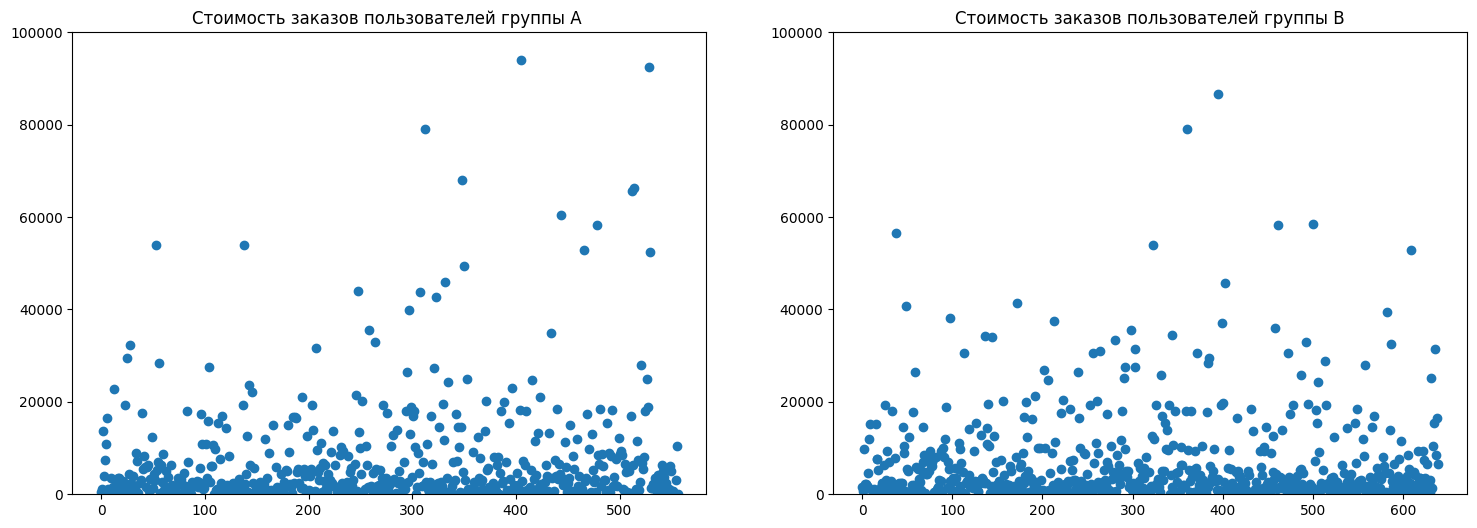

In [39]:
plt.figure(figsize=(18,6))

plt.subplot(1, 2, 1)
x_values = pd.Series(range(0,len(revenue_per_ordersA)))
plt.scatter(x_values, revenue_per_ordersA ) 
plt.title("Стоимость заказов пользователей группы А ")
plt.ylim(0,1e5)

plt.subplot(1, 2, 2)
x_values = pd.Series(range(0,len(revenue_per_ordersB)))
plt.scatter(x_values, revenue_per_ordersB ) 
plt.title("Стоимость заказов пользователей группы В")
plt.ylim(0,1e5)

plt.show()

**У большинства пользователей обеих групп сумма заказа не превышает 10 тысяч рублей, максимальная сумма заказа не превышает 100 тысяч руб. Однако на графике группы В можно заметить один невероятно большой заказ, превышающий 1,2 млн. рублей и еще один крупный заказ на 200 тысяч рублей. Судя по всему это и есть причина резкого скачка кумулятивного среднего чека 19 августа. В остальном группы очень похожи между собой.**

Посчитаем 95-й и 99-й перцентили стоимости заказов.

In [40]:
print(np.percentile(revenue_per_ordersA, [95, 99])) 

[26718.  62764.4]


В группе А не более 5% заказов на сумму свыше 26718 руб и не более 1% - на сумму свыше 62764 руб.

In [41]:
print(np.percentile(revenue_per_ordersB, [95, 99])) 

[28787.45 55579.06]


В группе В не более 5% заказов на сумму свыше 28787 руб и не более 1% - на сумму свыше 55579 руб.

**95-й и 99-й перцентили стоимости заказов равны:**
* **для группы А: 26718 и 62764 рублей;**
* **для группы В: 28787 и 55579 рублей.**

**Примем за аномальных пользователей в группе А тех, кто совершил заказ дороже 27000 рублей, а для группы В - тех, кто совершил заказ дороже 29 000 рублей. Так мы уберем пользователей с крупными заказами.**

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать определённое количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

In [42]:
sampleA = pd.concat([
                     ordersByUsersA['order_count'],
                     pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['order_count'])),
                     name='order_count')
                     ],axis=0)

sampleB = pd.concat([
                     ordersByUsersB['order_count'],
                     pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['order_count'])),
                     name='order_count')
                    ],axis=0)

Сформулируем гипотезы.

* Нулевая гипотеза : статистически значимых различий в среднем количестве заказов на посетителя между группами нет;
* Альтернативная гипотеза : статистически значимые различия в среднем количестве заказов на посетителя между группами есть.

Для тестирования воспользуемся критерием Манна-Уитни, уровень статистической значимости примем равным 5%.

In [43]:
alpha = 0.05
print(alpha, '- уровень статистической значимости')
p_value = st.mannwhitneyu(sampleA, sampleB, True, 'two-sided')[1]
print("{0:.3f}".format(p_value), '- p-значение')
print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1),
      '- относительная разница среднего количества заказов на посетителя группы В и этого же показателя группы А') 
if p_value > alpha:
    print('Cтатистически значимых различий в среднем количестве заказов на посетителя между группами нет')
else:
    print('Cтатистически значимые различия в среднем количестве заказов на посетителя между группами есть')

0.05 - уровень статистической значимости
0.017 - p-значение
0.138 - относительная разница среднего количества заказов на посетителя группы В и этого же показателя группы А
Cтатистически значимые различия в среднем количестве заказов на посетителя между группами есть


**Нулевая гипотеза отвергнута в сторону альтернативной. Cтатистически значимые различия в среднем количестве заказов на посетителя между группами есть. Относительная разница среднего количества заказов на посетителя группы В на 13.8% больше, чем в группе А.**

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

Сформулируем гипотезы.

* Нулевая гипотеза : статистически значимых различий в в среднем чеке заказа между группами нет;
* Альтернативная гипотеза : статистически значимые различия в в среднем чеке заказа между группами есть.

Для тестирования воспользуемся критерием Манна-Уитни, уровень статистической значимости примем равным 5%.

In [44]:
sampleC = orders[orders['group']=='A']['revenue']
sampleD = orders[orders['group']=='B']['revenue']
alpha = 0.05
print(alpha, '- уровень статистической значимости')
p_value = st.mannwhitneyu(sampleC, sampleD, True, 'two-sided')[1]
print("{0:.3f}".format(p_value), '- p-значение')
print("{0:.3f}".format(sampleD.mean() / sampleC.mean() - 1),
      '- относительная разница среднего чека группы В и среднего чека группы А') 
if p_value > alpha:
    print('Cтатистически значимых различий  в среднем чеке заказа между группами нет')
else:
    print('Cтатистически значимые различия  в среднем чеке заказа между группами есть')

0.05 - уровень статистической значимости
0.729 - p-значение
0.259 - относительная разница среднего чека группы В и среднего чека группы А
Cтатистически значимых различий  в среднем чеке заказа между группами нет


**Нулевая гипотеза не отвергается в сторону альтернативной. Cтатистически значимых различий  в среднем чеке заказа между группами нет, хотя относительная разница среднего чего группы В и среднего чека группы А равна 26%. Причина такого результата статистической проверки, скорее всего, заключается в выбросах.**

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

Ранее мы определили за аномальных пользователей в группе А тех, кто совершил от 3 заказов или совершил заказ дороже 27000 рублей, а для группы В - тех, кто совершил от 3 заказов или совершил заказ дороже 29 000 рублей.

Сделаем срезы пользователей с числом заказов больше 2 — usersWithManyOrders и пользователей, совершивших заказы дороже 27 000 рублей для группы А и 29 000 рублей для группы В — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers. Таблицы изначально поделим на группы.

In [45]:
usersWithManyOrdersA = ordersByUsersA[ordersByUsersA['order_count'] > 2]['visitor_id']
  
usersWithExpensiveOrdersA = orders[orders['revenue'] > 27000]['visitor_id']

abnormalUsersA = (
    pd.concat([usersWithManyOrdersA, usersWithExpensiveOrdersA], axis=0)
    .drop_duplicates()
    .sort_values()
)


usersWithManyOrdersB = ordersByUsersB[ordersByUsersB['order_count'] > 2]['visitor_id']
  
usersWithExpensiveOrdersB = orders[orders['revenue'] > 29000]['visitor_id']

abnormalUsersB = (
    pd.concat([usersWithManyOrdersB, usersWithExpensiveOrdersB], axis=0)
    .drop_duplicates()
    .sort_values()
)

Узнаем, как действия аномальных пользователей повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста.

In [46]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsersA))
        ]['order_count'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['order_count'])
            ),
            name='order_count',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsersB))
        ]['order_count'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['order_count'])
            ),
            name='order_count',
        ),
    ],
    axis=0,
) 

Применим статистический критерий Манна-Уитни к полученным выборкам с "очищенными" от выбросов данными.

Сформулируем гипотезы:
* Нулевая гипотеза : статистически значимых различий в среднем количестве заказов на посетителя между группами нет;
* Альтернативная гипотеза : статистически значимые различия в среднем количестве заказов на посетителя между группами есть.

Уровень статистической значимости примем равным 5%.

In [47]:
alpha = 0.05
print(alpha, '- уровень статистической значимости')
p_value = st.mannwhitneyu(sampleAFiltered, sampleBFiltered, True, 'two-sided')[1]
print("{0:.3f}".format(p_value), '- p-значение')
print("{0:.3f}".format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1),
      '- относительная разница среднего количества заказов на посетителя группы В и этого же показателя группы А') 
if p_value > alpha:
    print('Cтатистически значимых различий в среднем количестве заказов на посетителя между группами нет')
else:
    print('Cтатистически значимые различия в среднем количестве заказов на посетителя между группами есть')

0.05 - уровень статистической значимости
0.009 - p-значение
0.185 - относительная разница среднего количества заказов на посетителя группы В и этого же показателя группы А
Cтатистически значимые различия в среднем количестве заказов на посетителя между группами есть


**По "очищенным" данным p-значение = 0.9% (против 1.7% по "сырым" данным), что меньше уровня статистической значимости, следовательно гипотезу о том, что различий в среднем количестве заказов на посетителя между группами нет, отвергаем. Относительная разница в среднем количестве заказов на посетителя между группами составила 18.5%- на столько этот показатель группы В больше показателя группы А (против 13.8% по "сырым" данным).**

Расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным.

Результаты по среднему количеству заказов на посетителя практически не изменились. Проверим как изменились результаты по среднему чеку.

Сформулируем гипотезы.

* Нулевая гипотеза : статистически значимых различий в в среднем чеке заказа между группами нет;
* Альтернативная гипотеза : статистически значимые различия в в среднем чеке заказа между группами есть.

Для тестирования воспользуемся критерием Манна-Уитни, уровень статистической значимости примем равным 5%.

In [48]:
sampleA =  orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsersA)),
                )
            ]['revenue']
sampleB = orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsersB)),
                )
            ]['revenue']
alpha = 0.05
print(alpha, '- уровень статистической значимости')
p_value = st.mannwhitneyu(sampleA, sampleB, True, 'two-sided')[1]
print("{0:.3f}".format(p_value), '- p-значение')
print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1),
      '- относительная разница среднего чека группы В и среднего чека группы А') 
if p_value > alpha:
    print('Cтатистически значимых различий  в среднем чеке заказа между группами нет')
else:
    print('Cтатистически значимые различия  в среднем чеке заказа между группами есть')

0.05 - уровень статистической значимости
0.996 - p-значение
0.021 - относительная разница среднего чека группы В и среднего чека группы А
Cтатистически значимых различий  в среднем чеке заказа между группами нет


**По "oчищенным" данным p-значение = 99.6% (против 73% по "сырым" данным), что ̶з̶н̶а̶ч̶и̶т̶е̶л̶ь̶н̶о̶ больше уровня статистической значимости, следовательно гипотезу о том, что различий в сумме среднего чека между группами нет, не отвергаем.
Относительная разница суммы среднего чека между группами составила 2% (против 26% по "сырым" данным)- теперь такого значительного отличия суммы среднего чека группы В, как раньше, нет.**

## Выводы и рекомендации

Из представленных 9 гипотез с применением фреймворка RICE была выбрана как наиболее приоритетная гипотеза - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"

По результатам А/В - тестирования гипотезы были сделаны следующие выводы:

* кумулятивная выручка группы B после 2 августа стабильно выше кумулятивной выручки группы А. На конец августа этот показатель для группы B оказался в полтора раза выше. Заметен также резкий скачок кумулятивной выручки в группе B с 18 на 19 августа;

* кумулятивный средний чек группы В в период с 11 по 15 августа падает ниже уровня группы А, но затем резко растет, что еще раз подтверждает, что в группе В в период 18-19 августа была крупная покупка, которая увеличила размер кумулятивного среднего чека;

* начиная с 6 августа кумулятивное среднее количество заказов на посетителя в группе B оказалось больше аналогичного показателя группы А, но оно имело слабую тенденцию к снижению;

* у большинства пользователей обеих групп сумма заказа не превышает 10 тысяч рублей, максимальная сумма заказа не превышает 100 тысяч руб. Однако на графике группы В можно заметить один невероятно большой заказ, превышающий 1,2 млн. рублей и еще один крупный заказ на 200 тысяч рублей. Судя по всему это и есть причина резкого скачка кумулятивного среднего чека 19 августа. В остальном группы очень похожи между собой;

Был произведен расчет статистической значимости различий в среднем количестве заказов на посетителя и в сумме среднего чека между группами по «сырым» и "очищенным" от выбросов данным:

* при проведении тестов с использованием критерия Манна-Уитни оказалось, что гипотеза о равенстве среднего количества заказов на посетителя между группами отвергнута, а относительная разница этого показателя группы В на 13.8% больше, чем в группе А. При тестировании "очищенных" от выбросов данных результат также подтвердился: среднее количество заказов на посетителя отличается, а относительная разница составила 18.5% - на столько этот показатель группы В больше аналогичного показателя группы А;

* гипотеза о том, что различий в сумме среднего чека между группами нет, не отвергнута с очень большой уверенностью, а относительная разница суммы среднего чека между группами составила 2% (против 26% по "сырым" данным) - после удаления выбросов разница между чеками обоих групп стремится к нулю.

Средний чек в результате тестирования гипотезы почти не изменился, а вот среднее количество заказов на посетителя повысилось почти на 20%.

**Рекомендуется остановить тест и зафиксировать победу группы B.**